In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,classification_report
from nltk.tokenize import word_tokenize

import seaborn as sns 
plt.style.use('ggplot')

import torch
import torch.nn as nn


In [2]:
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

fake['class'] = 0
real['class'] = 1

In [3]:
news_df = pd.concat([fake, real], ignore_index=True, sort=False)
news_df = news_df[['text', 'class']]

print(news_df['class'].value_counts())


0    23481
1    21417
Name: class, dtype: int64


In [4]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [5]:
def normalize(text_data):
    normalized = [re.sub(r'https?://\S+|www\.\S+', '', text.lower()) for text in text_data]
    normalized = [re.sub(r'\W', ' ', text) for text in normalized]
    normalized = [re.sub(r'\n', ' ', text) for text in normalized]
    normalized = [re.sub(r' +', ' ', text) for text in normalized]
    normalized = [text.strip() for text in normalized]
    tokenized = [word_tokenize(text) for text in normalized]

    return tokenized

news_df['tokenized_text'] = normalize(news_df['text'])


print(news_df['tokenized_text'].head(5))

0    [donald, trump, just, couldn, t, wish, all, am...
1    [house, intelligence, committee, chairman, dev...
2    [on, friday, it, was, revealed, that, former, ...
3    [on, christmas, day, donald, trump, announced,...
4    [pope, francis, used, his, annual, christmas, ...
Name: tokenized_text, dtype: object


In [6]:

X_train = normalize(X_train)
X_test = normalize(X_test)


In [7]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [8]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 256),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         73984     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, validation_split=0.1, batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/2
324/324 [==============================] - 272s 815ms/step - loss: 0.1244 - accuracy: 0.9522 - val_loss: 0.0476 - val_accuracy: 0.9841
Epoch 2/2
324/324 [==============================] - 273s 844ms/step - loss: 0.0422 - accuracy: 0.9862 - val_loss: 0.0488 - val_accuracy: 0.9777


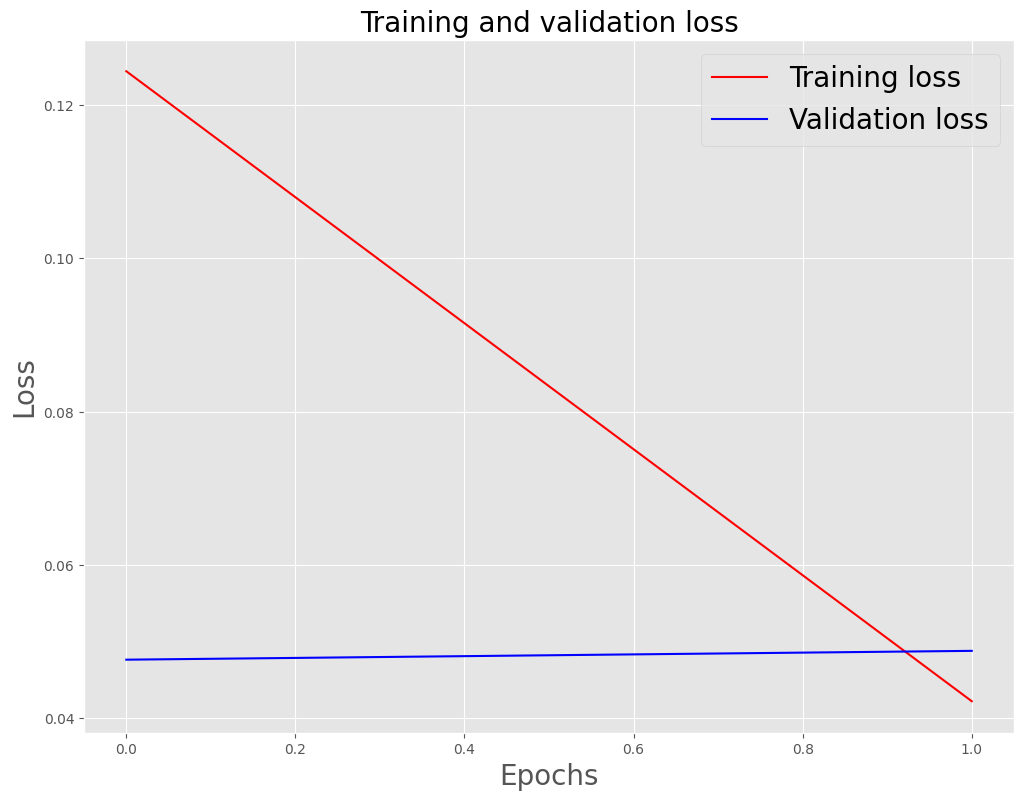

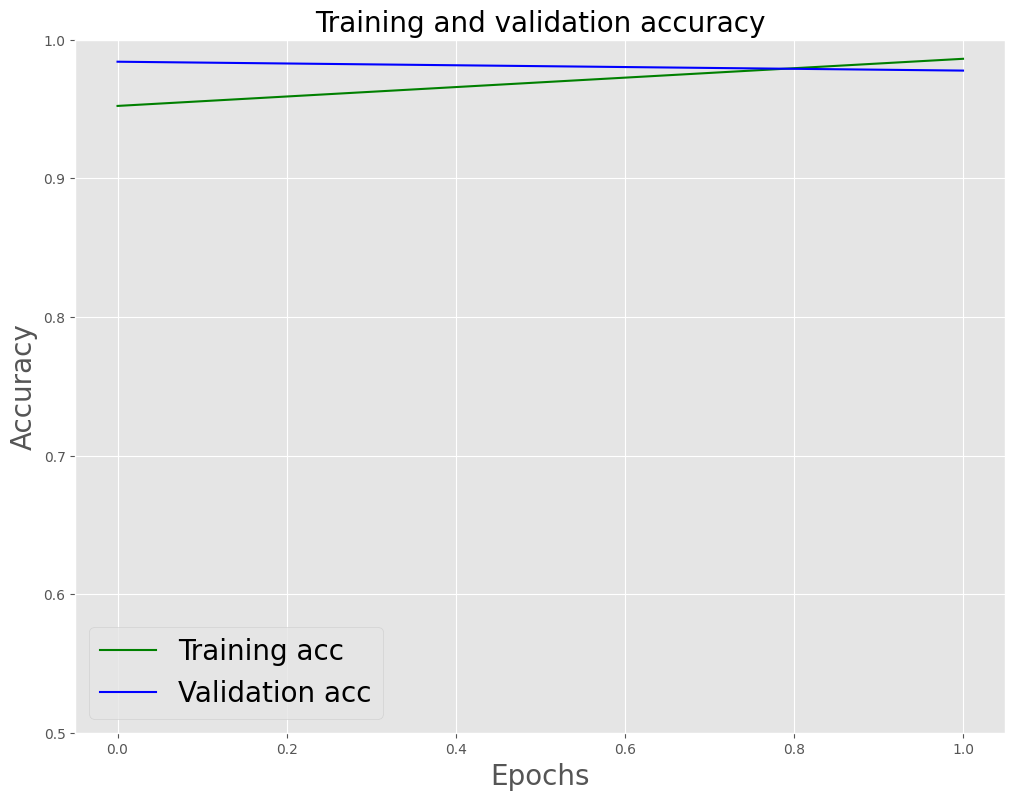

In [12]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [13]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 28s 101ms/step - loss: 0.0515 - accuracy: 0.9785


[0.051503922790288925, 0.9785078167915344]

In [14]:
pred = model.predict(X_test)

predictions = [1 if i >= 0.5 else 0 for i in pred]



281/281 [==============================] - 29s 99ms/step


In [15]:
print('Accuracy:', accuracy_score(predictions, y_test))
print('Precision:', precision_score(predictions, y_test))
print('Recall:', recall_score(predictions, y_test))

Accuracy: 0.9785077951002227
Precision: 0.9666512274201019
Recall: 0.9883968742600048


In [ ]:
#새로운 기사를 대입
new_article = ""

normalized_article = normalize([new_article])
tokenized_article = tokenizer.texts_to_sequences(normalized_article)

pred = model.predict(tokenized_article)

probability = tf.nn.sigmoid(pred)[0, 0]

threshold = 0.5
predicted_class = 1 if probability > threshold else 0

if predicted_class == 0:
    print("The news article is predicted as FAKE.")
else:
    print("The news article is predicted as REAL.")
    
print(normalized_article)    
print(tokenized_article)
print(probability)